## Заряженный методами KNN

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm as tq
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [64]:
X, y = datasets.make_classification(n_samples=1000, n_classes=3, n_informative=3,
                                    n_features=10)

X_train, X_test, y_train, y_train = train_test_split(X, y)

In [65]:
class KNN:
    def __init__(self, k=3, method="std"):
        self.k = k
        self.method = method
        self.task = None
        self.last_indexes = []

    def change_neihgbors_direction(self):
        # метод для смены класса наблюдению в случае зацикливания змейки
        index = self.last_indexes[random.randint(0, self.k - 1)]
        choice = self.y_train[index]

        while choice == self.y_train[index]:
            choice = random.choice([1, 2, 3])

        self.y_train[index] = choice

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.find_task_type(y_train)
            
    def find_task_type(self, y_train):
        # метод распознавания типа решаемой задачи - классификация или регрессия
        self.task = "regression"
        if (y_train == y_train.astype(int)).sum() / len(y_train):
            self.task = "classification"

    def distance(self, x_test, x_train):
        return np.sqrt(np.sum((x_test - x_train)**2))

    def predict(self, X_test):
        labels = [self.find_labels(x_test) for x_test in X_test]
        return np.array(labels)

    def find_labels(self, x_test):
        distances = [self.distance(x_test, x_train) for x_train in self.X_train]
        k_nearest = np.argsort(distances)[:self.k]
        self.last_indexes = k_nearest
        k_labels = [self.y_train[i] for i in k_nearest]

        if self.task == "regression":
            return np.sum(k_labels) / self.k

        if self.method == "std":
            return self.most_common(k_labels)

        max_ = max(k_nearest)
        alpha = 0.1

        k_nearest = [1 / ((i + max_ * alpha) / max_) for i in k_nearest]

        a = [i for i in range(int(max(k_labels) + 1))]
        summ = [0] * int(max(k_labels) + 1)

        for index, value in enumerate(k_nearest):
            summ[int(k_labels[index])] += value

        return a[np.argsort(summ)[-1]]

    def most_common(self, k_labels):
        a = tuple(set(k_labels))
        most_common = [k_labels.count(i) for i in a]
        index = np.argsort(most_common)[-1]

        if len(set(most_common)) == 1 or len(most_common) == len(k_labels):
            return random.choice(a)

        return a[index]
    
    # методы проверки качества моделей для обоих типов задач
    def score(self, predicted, y_test):
        return (predicted == y_test).sum() / len(y_test)

    def r2(self, predicted, y_test):
        return 1 - np.sum((predicted - y_test)**2) / np.sum(
            (y_test.mean() - y_test)**2)
    
    # встроенный метод скользящего контроля (кросс валидация по фолдам)
    def cv(self, X, y, cv=5, disable=False):
        self.find_task_type(y)
        
        y = np.reshape(y, (len(y), 1))
        data = np.concatenate((X, y), axis=1)
        np.random.shuffle(data)

        data = pd.DataFrame(data)
        score = []

        for i in tq(range(cv), desc="Скользящий контроль: ", disable=disable):
            lenght = int(len(y) / cv)

            X_test = data.iloc[i * lenght:i * lenght + lenght, :-1]
            X_train = data.drop(index=X_test.index).iloc[:, :-1]

            y_test = data.iloc[i * lenght:i * lenght + lenght, -1]
            y_train = data.drop(index=X_test.index).iloc[:, -1]

            clf = KNN(method="new")
            clf.fit(np.array(X_train), np.array(y_train))
            predicted = clf.predict(np.array(X_test))

            if self.task == "classification":
                score.append(clf.score(predicted, np.array(y_test)))
            else:
                score.append(clf.r2(predicted, np.array(y_test)))

        return np.array(score)
    
    # метод оценки важности признаков (permutation importance)
    def feature_importance(self, X_res, y_res, cv=5):
        clf = KNN()
        original = clf.cv(X_res, y_res, cv=cv, disable=True).mean()

        importance = []

        for i in tq(range(X_res.shape[1]), desc="Оценка важности признаков"):
            X_new = X_res.copy()
            np.random.shuffle(X_new[:, i])

            cv = clf.cv(X_new, y_res, cv=5, disable=True)
            importance.append(np.mean(cv))

        importance = np.array(importance - original)

        fig, axs = plt.subplots(figsize=(len(importance), 1))
        sns.heatmap(importance[np.newaxis, :], annot=True, fmt='0.2f', ax=axs, cbar=False)
        plt.savefig("importance.png")
        plt.show()

## Скользящий контроль

In [66]:
clf = KNN()
clf.cv(X, y)

Скользящий контроль: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.06s/it]


array([0.75 , 0.725, 0.73 , 0.66 , 0.785])

## Подбор параметра k

In [67]:
score = []
neighbors = []

for k in range(3, 30, 3):
    clf = KNN(k=k)
    score.append(clf.cv(X, y, cv=5, disable=True).mean())
    neighbors.append(k)

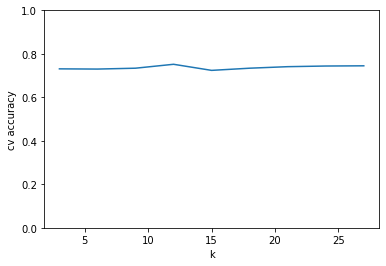

In [68]:
plt.plot(neighbors, score)
plt.ylim(0, 1)
plt.xlabel("k")
plt.ylabel("cv accuracy")
plt.savefig("cv_vs_k.png")
plt.show()

## Важность признаков

Оценка важности признаков: 100%|███████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.47s/it]


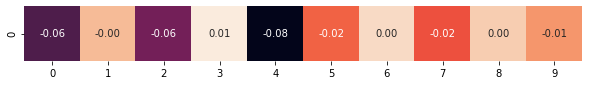

In [69]:
clf.feature_importance(X, y, cv=5)